# Sentiment Analysis on StockTwits

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

#from helper import plot_history
from helper import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


data_dir = './'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(data_dir+'stock_twits_processed.csv')
df.head(2)

,message_body,sentiment,timestamp,message_processed
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,great buy ill wait
1,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,staanalystalert jefferies maintains rating hol...


## Prepare input for Model
- train, test, val split
- tokenize the text
- Pad the Sequences to a certain length
- convert the y labels to categorical

In [3]:
def split_data(data):
    X_train_, X_test, y_train_, y_test = train_test_split(data['message_processed'].values, data['sentiment'].values, test_size=0.2)
    X_train,  X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [4]:
MAX_SEQ_LEN = 2000 # length of each text
MAX_WORDS   = 1000 # use only this many max used words

def prepare_data_for_model(X_train, X_val, X_test,
                               y_train, y_val, y_test, 
                               text_to_matrix=False):
    
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)

    if text_to_matrix:
        X_train = tokenizer.texts_to_matrix(X_train)
        X_val   = tokenizer.texts_to_matrix(X_val)    
        X_test  = tokenizer.texts_to_matrix(X_test)
    else:
        X_train = tokenizer.texts_to_sequences(X_train)
        X_val   = tokenizer.texts_to_sequences(X_val)    
        X_test  = tokenizer.texts_to_sequences(X_test)

        X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
        X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
        X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    
    y_train = to_categorical(y_train)
    y_val   = to_categorical(y_val)
    y_test  = to_categorical(y_test)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, tokenizer)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import LSTM, Bidirectional, Conv1D
from keras.layers import MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

## Model: Dense

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test, 
                                     text_to_matrix=True)

X_train.shape: (386097, 1000) y_train.shape:(386097, 5)
X_test.shape: (128700, 1000) y_test.shape:(128700, 5)
X_val.shape: (128699, 1000) y_val.shape:(128699, 5)


In [20]:
def make_model(X, y):
    model = Sequential()
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model1 = make_model(X_train, y_train)
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                16016     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [22]:
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_val, y_val), 
                      batch_size=128,
                      epochs=2,
                      verbose=1)

Epoch 1/2
3017/3017 [==============================] - 6s 2ms/step - loss: 1.0337 - accuracy: 0.5898 - val_loss: 0.9990 - val_accuracy: 0.6040
Epoch 2/2
3017/3017 [==============================] - 4s 1ms/step - loss: 1.0211 - accuracy: 0.5949 - val_loss: 0.9920 - val_accuracy: 0.6058


4022/4022 [==============================] - 2s 564us/step - loss: 0.9870 - accuracy: 0.6069
Test accuracy: 60.69%


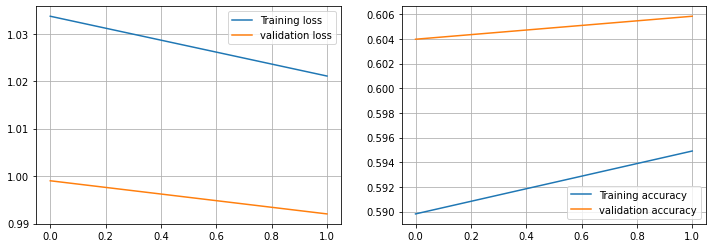

In [23]:
score = model1.evaluate(X_test, y_test, batch_size=32)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history1)

## Model: LSTM+Dense

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test, 
                                     text_to_matrix=True)

X_train.shape: (386097, 1000) y_train.shape:(386097, 5)
X_test.shape: (128700, 1000) y_test.shape:(128700, 5)
X_val.shape: (128699, 1000) y_val.shape:(128699, 5)


In [11]:
def make_model(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = make_model(X_train, y_train)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          16000     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 18,197
Trainable params: 18,197
Non-trainable params: 0
_________________________________________________________________


In [12]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=5,
                    batch_size=32,
                    verbose=1)

Epoch 1/5
   92/12066 [..............................] - ETA: 50:22 - loss: 1.6100 - accuracy: 0.1936

KeyboardInterrupt: 

In [ ]:
from helper import plot_history

score = model2.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history2)

I was able to reach an accuracy of around 50% with this but it took roughly 5 minutes for 
single epoch. So didn't run.

## Model: Bidirectional LSTM

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test, 
                                     text_to_matrix=False)

In [ ]:
def make_model_bidirectional(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Conv1D(32, kernel_size = 3, padding = "valid"))
    model.add(GlobalMaxPool1D())
    #model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model3 = make_model_bidirectional(X_train, y_train)
model3.summary()

In [ ]:
history3 = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=10,
                    batch_size=16,
                    verbose=1)

In [ ]:
from helper import plot_history

score = model3.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history3)

## Evaluation on test set

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
ypred = model1.predict(X_test)

In [52]:
np.argmax(y_test,axis=1)

array([3, 3, 4, ..., 4, 3, 4])

[[560 119  71  54  34]
 [ 80 497  96  93  71]
 [ 28  77 589 112  38]
 [ 60  93 127 403 133]
 [ 31  29  52 147 551]]


<AxesSubplot:>

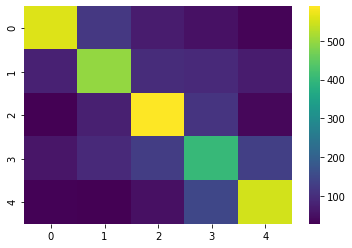

In [55]:
confusionmatrix=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(ypred,axis=1))
print ( confusionmatrix )
sns.heatmap(confusionmatrix, cmap='viridis')


## Save the Model, tokenizer and configs

In [56]:
import pickle
import json

model2.save('model_dense')
with open('tokenizer.pkl', 'wb') as fp:
    pickle.dump(tokenizer, fp)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_dense/assets


## Load the saved Model, tokenizer and configs

In [58]:
# loading the saved model, vocab, filtered_words
from tensorflow.keras.models import load_model
model = load_model('./model_dense')

with open('tokenizer.pkl', 'rb') as fp:
    tokenizer=pickle.load(fp)

print ("Model Loaded.")

Model Loaded.


## Predictions

In [59]:
def Prediction(txt_orig, model=model, tokenizer=tokenizer, MAX_SEQ_LEN=MAX_SEQ_LEN):
    sent_dict={0:'very_bad', 1:'bad', 2:'neutral', 3:'good', 4:'very_good'}
    txt = process_twt(txt_orig)
    X_in = tokenizer.texts_to_sequences([txt])
    X_in = pad_sequences(X_in, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    y_out = model.predict(X_in)
    sent = np.argmax(y_out,axis=1)[0]

    print (f"The following text\n\n {txt_orig} \n\n\
    has a sentiment \n {sent} ({sent_dict[sent]})\n\n on the following scale\n\n\
    {sent_dict}")

text = " $AAPL had a big increase. I am really happy for this."
Prediction(text)

The following text

  $AAPL had a big increase. I am really happy for this. 

    has a sentiment 
 4 (very_good)

 on the following scale

    {0: 'very_bad', 1: 'bad', 2: 'neutral', 3: 'good', 4: 'very_good'}
